# Importing and Reading Data

In [ ]:
from tensorflow.keras import layers
from tensorflow import keras
import tensorflow as tf

from sklearn.model_selection import train_test_split
from ast import literal_eval

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from keras.layers import Dense
from keras.models import Sequential

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
data = pd.read_csv("/content/drive/MyDrive/Tri NIT/train.csv/train.csv")
df = data.copy()

In [ ]:
df.head()

Description  Commenting  \
0  Was walking along crowded street, holding mums...           0   
1  This incident took place in the evening.I was ...           0   
2  I WAS WAITING FOR THE BUS. A MAN CAME ON A BIK...           1   
3                 Incident happened inside the train           0   
4  I witnessed an incident when a chain was bruta...           0   

   Ogling/Facial Expressions/Staring  Touching /Groping  
0                                  0                  1  
1                                  1                  0  
2                                  0                  0  
3                                  0                  0  
4                                  0                  0

In [ ]:
lengths = []
for i in df["Description"]:
  lengths.append(len(i.split(" ")))
print("Maximum Number of words: ", max(lengths))
print(f"Minimum words: {min(lengths)}")
print(f"Average words: {sum(lengths)/len(lengths)}")

Maximum Number of words:  1042
Minimum words: 1
Average words: 23.616025552006665


# Text Preprocessing

## Segregating test and train

In [ ]:
texts = df['Description']
labels = df.iloc[:, 1:]

In [ ]:
texts[:5]

0    Was walking along crowded street, holding mums...
1    This incident took place in the evening.I was ...
2    I WAS WAITING FOR THE BUS. A MAN CAME ON A BIK...
3                   Incident happened inside the train
4    I witnessed an incident when a chain was bruta...
Name: Description, dtype: object

In [ ]:
labels[:5]

Commenting  Ogling/Facial Expressions/Staring  Touching /Groping
0           0                                  0                  1
1           0                                  1                  0
2           1                                  0                  0
3           0                                  0                  0
4           0                                  0                  0

## Preprocessing process

In [ ]:
import re
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

In [ ]:
def preprocess_text(texts, maxlen):
    texts = [re.sub(r'http\S+', '', text) for text in texts]
    texts = [re.sub(r'[^A-Za-z0-9]+', ' ', text) for text in texts]
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(texts)
    sequences = tokenizer.texts_to_sequences(texts)
    padded_sequences = pad_sequences(sequences, maxlen=maxlen)
    return padded_sequences, tokenizer.word_index

In [ ]:
maxlen = 20
padded_sequences, word_index = preprocess_text(texts, maxlen)

## Transforming multi label data into binary values

In [ ]:
from sklearn.preprocessing import MultiLabelBinarizer
mlb = MultiLabelBinarizer()
binary_labels = mlb.fit_transform(labels)

KeyError: 0

In [ ]:
mlb.inverse_transform([0,1])

AttributeError: 'list' object has no attribute 'shape'

In [ ]:
binary_labels[0]

array([1, 1])

## Splitting into train and test data

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(padded_sequences, labels, test_size=0.2, random_state=42)

# Model Training

In [ ]:
from keras.layers import Embedding, LSTM, Dense, SpatialDropout1D, Bidirectional, Dropout
from keras.optimizers import Adam

## Hamming Score

In [ ]:
binary_labels.shape[1]

2

In [ ]:
from keras import backend as K
def hamming_score(y_true, y_pred):
    return K.mean(K.cast(K.not_equal(y_true, K.round(y_pred)), K.floatx()))

In [ ]:
model = Sequential()
model.add(Embedding(input_dim=len(word_index) + 1, output_dim=128, input_length=maxlen))
model.add(LSTM(units=128))
model.add(Dense(units=3, activation='sigmoid'))

In [ ]:
optimizer = Adam(lr=0.001)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
from keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

In [ ]:
model.fit(X_train, y_train, epochs=5, batch_size=32, validation_split=0.2)

Epoch 1/5
144/144 [==============================] - 12s 67ms/step - loss: 0.5605 - accuracy: 0.6098 - val_loss: 0.4801 - val_accuracy: 0.6155
Epoch 2/5
144/144 [==============================] - 8s 52ms/step - loss: 0.4194 - accuracy: 0.6884 - val_loss: 0.4449 - val_accuracy: 0.7188
Epoch 3/5
144/144 [==============================] - 9s 64ms/step - loss: 0.3400 - accuracy: 0.7070 - val_loss: 0.4554 - val_accuracy: 0.6806
Epoch 4/5
144/144 [==============================] - 9s 60ms/step - loss: 0.2798 - accuracy: 0.7077 - val_loss: 0.5045 - val_accuracy: 0.5642
Epoch 5/5
144/144 [==============================] - 8s 57ms/step - loss: 0.2381 - accuracy: 0.7127 - val_loss: 0.5354 - val_accuracy: 0.6302


In [ ]:
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test Accuracy: {accuracy}')

46/46 [==============================] - 1s 12ms/step - loss: 0.4964 - accuracy: 0.6898
Test Accuracy: 0.6897987723350525


In [ ]:
y_pred = model.predict(X_test)

46/46 [==============================] - 1s 13ms/step


In [ ]:
hamming_score = np.mean(np.not_equal(y_test, np.round(y_pred)))
print(f'Hamming Score: {1 - hamming_score}')

Hamming Score: Commenting                           0.775850
Ogling/Facial Expressions/Staring    0.792505
Touching /Groping                    0.847328
dtype: float64


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3502: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


# SHAP

In [ ]:
!pip install lime

In [ ]:
from lime import lime_text
from lime.lime_text import LimeTextExplainer

In [ ]:
def predict_proba(texts):
    sequences = tokenizer.texts_to_sequences(texts)
    X_pred = pad_sequences(sequences, maxlen=maxlen)
    return model.predict(X_pred)


In [ ]:
explainer = LimeTextExplainer(class_names=labels)

In [ ]:
def preprocess_text(texts, maxlen):
    texts = [re.sub(r'http\S+', '', text) for text in texts]
    texts = [re.sub(r'[^A-Za-z0-9]+', ' ', text) for text in texts]
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(texts)
    sequences = tokenizer.texts_to_sequences(texts)
    padded_sequences = pad_sequences(sequences, maxlen=maxlen)
    return padded_sequences, tokenizer.word_index

In [ ]:
new_texts = "Catcalls and passing comments were two of the ghastly things the Delhi police at the International Airport put me and my friend through. It is appalling that the protectors and law enforcers at the airport can make someone so uncomfortable."
a,b = preprocess_text(new_texts, 20)

In [ ]:
pred = model.predict(a)

8/8 [==============================] - 0s 26ms/step


In [ ]:
pred

array([[0.477508  , 0.15208812, 0.16684808],
       [0.40323126, 0.21678656, 0.23615952],
       [0.45466098, 0.26515022, 0.26325554],
       [0.477508  , 0.15208812, 0.16684808],
       [0.40323126, 0.21678656, 0.23615952],
       [0.35382596, 0.19443496, 0.17320023],
       [0.35382596, 0.19443496, 0.17320023],
       [0.42884436, 0.19967233, 0.23800172],
       [0.4293275 , 0.25788188, 0.24603413],
       [0.40323126, 0.21678656, 0.23615952],
       [0.37407163, 0.24105683, 0.2721426 ],
       [0.3212017 , 0.26531422, 0.20360321],
       [0.4293275 , 0.25788188, 0.24603413],
       [0.3575581 , 0.24649356, 0.15158385],
       [0.40323126, 0.21678656, 0.23615952],
       [0.42884436, 0.19967233, 0.23800172],
       [0.42884436, 0.19967233, 0.23800172],
       [0.31390044, 0.16474873, 0.23979469],
       [0.37407163, 0.24105683, 0.2721426 ],
       [0.3714698 , 0.16891381, 0.20155023],
       [0.4293275 , 0.25788188, 0.24603413],
       [0.477508  , 0.15208812, 0.16684808],
       [0.

Text: C
Predicted labels: [1 0 0]
Text: a
Predicted labels: [1 0 0]
Text: t
Predicted labels: [1 0 0]
Text: c
Predicted labels: [1 0 0]
Text: a
Predicted labels: [1 0 0]
Text: l
Predicted labels: [0 0 0]
Text: l
Predicted labels: [0 0 0]
Text: s
Predicted labels: [1 0 0]
Text:  
Predicted labels: [1 0 0]
Text: a
Predicted labels: [1 0 0]
Text: n
Predicted labels: [0 0 0]
Text: d
Predicted labels: [0 0 0]
Text:  
Predicted labels: [1 0 0]
Text: p
Predicted labels: [0 0 0]
Text: a
Predicted labels: [1 0 0]
Text: s
Predicted labels: [1 0 0]
Text: s
Predicted labels: [1 0 0]
Text: i
Predicted labels: [0 0 0]
Text: n
Predicted labels: [0 0 0]
Text: g
Predicted labels: [0 0 0]
Text:  
Predicted labels: [1 0 0]
Text: c
Predicted labels: [1 0 0]
Text: o
Predicted labels: [0 0 0]
Text: m
Predicted labels: [0 0 0]
Text: m
Predicted labels: [0 0 0]
Text: e
Predicted labels: [0 0 0]
Text: n
Predicted labels: [0 0 0]
Text: t
Predicted labels: [1 0 0]
Text: s
Predicted labels: [1 0 0]
Text:  
Predic

In [ ]:
def predict_fn(texts):
    padded_sequences,  wr = preprocess_text(text)
    return model.predict(padded_sequences)

# Initialize LIME TextExplainer
explainer = LimeTextExplainer(class_names=['label1', 'label2', 'label3'])

# Choose a text instance from your dataset (e.g., X_test[0])
text_instance = "Catcalls and passing comments were two of the ghastly things the Delhi police at the International Airport put me and my friend through. It is appalling that the protectors and law enforcers at the airport can make someone so uncomfortable.."
# Explain predictions
exp = explainer.explain_instance(text_instance, predict_fn, num_features=10)

# Visualize explanation
exp.show_in_notebook()

ValueError: not enough values to unpack (expected 2, got 1)

In [ ]:
new_texts = "I was dragged into a van , I somehow managed to escape and was helped by few people . It happened during evening 8 pm."
for i, text in enumerate(new_texts):
    print(f'Text: {text}')
    print(f'Predicted labels: {predicted_labels[i]}')

Text: I
Predicted labels: (0, 1)
Text:  
Predicted labels: (0, 1)
Text: w
Predicted labels: (0, 1)
Text: a
Predicted labels: (0, 1)
Text: s
Predicted labels: (0, 1)
Text:  
Predicted labels: (0, 1)
Text: d
Predicted labels: (0, 1)
Text: r
Predicted labels: (0, 1)
Text: a
Predicted labels: (0, 1)
Text: g
Predicted labels: (0, 1)
Text: g
Predicted labels: (0, 1)
Text: e
Predicted labels: (0, 1)
Text: d
Predicted labels: (0, 1)
Text:  
Predicted labels: (0, 1)
Text: i
Predicted labels: (0, 1)
Text: n
Predicted labels: (0,)
Text: t
Predicted labels: (0, 1)
Text: o
Predicted labels: (0, 1)
Text:  
Predicted labels: (0, 1)
Text: a
Predicted labels: (0, 1)
Text:  
Predicted labels: (0, 1)
Text: v
Predicted labels: (0, 1)
Text: a
Predicted labels: (0, 1)
Text: n
Predicted labels: (0,)
Text:  
Predicted labels: (0, 1)
Text: ,
Predicted labels: (0, 1)
Text:  
Predicted labels: (0, 1)
Text: I
Predicted labels: (0, 1)
Text:  
Predicted labels: (0, 1)
Text: s
Predicted labels: (0, 1)
Text: o
Predic

In [ ]:
def predict_fn(texts):
    padded_sequences, _ = preprocess_text(text, maxlen=maxlen)
    return model.predict(padded_sequences)

# Initialize LIME TextExplainer
explainer = LimeTextExplainer(class_names=['label1', 'label2', 'label3'])

# Choose a text instance from your dataset (e.g., X_test[0])
text_instance = "Catcalls and passing comments were two of the ghastly things the Delhi police at the International Airport put me and my friend through. It is appalling that the protectors and law enforcers at the airport can make someone so uncomfortable.."
# Explain predictions
exp = explainer.explain_instance(text_instance, predict_fn, num_features=10)

# Visualize explanation
exp.show_in_notebook()

1/1 [==============================] - 0s 50ms/step


ValueError: Found input variables with inconsistent numbers of samples: [5000, 1]

In [ ]:
y_train

In [ ]:
exp.save_to_file('explanation.html')

In [ ]:
import joblib
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
import re
from sklearn.multiclass import OneVsRestClassifier
from sklearn import metrics
from sklearn.svm import SVC

X_train = data["Description"]
train_y= data.drop("Description", axis=1)

def preprocess(sentence):

    """Do all the Preprocessing as shown above and
    return a tuple contain preprocess_email,preprocess_subject,preprocess_text for that Text_data"""
    sentence = sentence.lower()
    sentence = re.sub('<[^>]+>', '', sentence)    #removing words under tags
    sentence = re.sub(r"\([^()]*\)", "", sentence)  #removing words under parentheses
    sentence = re.sub('[^A-Za-z0-9]+', " ", sentence)  # removing all special char and spaces ect.
    sentence = re.sub(r'\w+:\s?',"", sentence)   # removing word ending with ':'
      # sentence = re.sub(r"n\'t", " not", phrase)

      #decontractions
    sentence = re.sub(r"n\'t", " not", sentence)
    sentence = re.sub(r"\'re", " are", sentence)
    sentence = re.sub(r"\'s", " is", sentence)
    sentence = re.sub(r"\'d", " would", sentence)
    sentence = re.sub(r"\'ll", " will", sentence)
    sentence = re.sub(r"\'t", " not", sentence)
    sentence = re.sub(r"\'ve", " have", sentence)
    sentence = re.sub(r"\'m", " am", sentence)
    short_word =re.compile(r'\W*\b\w{1,2}\b')  # removing short word=2
    sentence = short_word.sub('', sentence)
    return( sentence)
    # return (emails)

preprocessed_reviews = []
for sentence in X_train.values:
    preprocessed_reviews.append(preprocess(sentence))

# preprocessed_text = preprocess(X_train)

preprocessed_reviews[0]

def predict(string):
    clf = joblib.load('model.pkl')
    count_vect = joblib.load('count_vect.pkl')
    review_text = preprocess(string)
    test_vect = count_vect.transform(([review_text]))
    pred = clf.predict(test_vect)

    if pred[0][0]==0 & pred[0][1]==0 & pred[0][2]==0:
      prediction = "No harassment"
    elif pred[0][0]==1 & pred[0][1]==1 & pred[0][2]==1:
      prediction = "case comes under all category: commenting, ogling, touching"
    elif pred[0][0]==0 & pred[0][1]==0 & pred[0][2]==1:
      prediction = "case comes under 3rd category: touching"
    elif pred[0][0]==0 & pred[0][1]==1 & pred[0][2]==1:
      prediction = "case comes under 2nd and 3rd category: ogling and touching"
    elif pred[0][0]==1 & pred[0][1]==1 & pred[0][2]==0:
      prediction = "case comes under 1st and 2nd category: commenting and ogling"
    elif pred[0][0]==1 & pred[0][1]==0 & pred[0][2]==0:
      prediction = "case comes under 1st category: commenting"
    else:
      prediction = "error"
    return prediction

tf_vectorize= TfidfVectorizer()
tf_vectorize.fit(preprocessed_reviews)
joblib.dump(tf_vectorize, 'count_vect.pkl')
X = tf_vectorize.transform(preprocessed_reviews)

clf = OneVsRestClassifier(SVC(probability=True), n_jobs=-1)
clf.fit(X, train_y)
joblib.dump(clf, 'model.pkl')

['model.pkl']

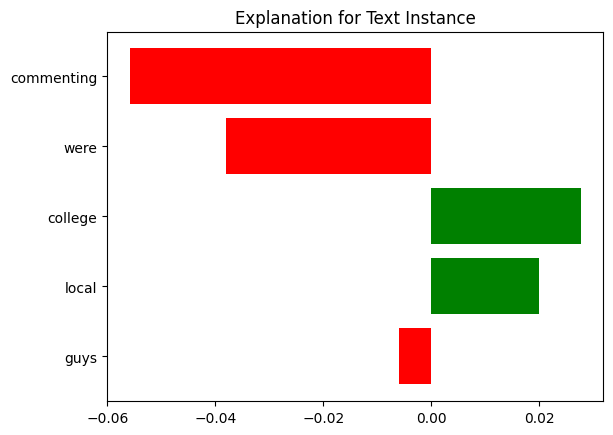

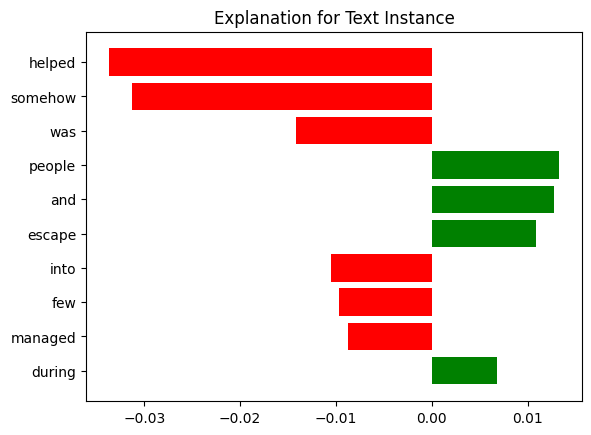

In [ ]:
import joblib
import numpy as np
from lime import lime_text
from lime.lime_text import LimeTextExplainer
import matplotlib.pyplot as plt

# Load the trained model and vectorizer
clf = joblib.load('model.pkl')
count_vect = joblib.load('count_vect.pkl')

# Define the LIME explainer
explainer = LimeTextExplainer(class_names=['label1', 'label2', 'label3'])

# Function to preprocess text
def preprocess_text(text):
    # Your preprocess function
    return preprocess(text)

# Function to predict using your model
def predict_proba(texts):
    # Preprocess the text
    preprocessed_texts = [preprocess_text(text) for text in texts]
    # Vectorize the preprocessed text
    vectorized_texts = count_vect.transform(preprocessed_texts)
    # Predict probabilities using the loaded model
    probabilities = clf.predict_proba(vectorized_texts)
    return probabilities

# Generate explanations for each text instance
text_instances = ["local college guys were commenting.", "I was dragged into a van , I somehow managed to escape and was helped by few people . It happened during evening 8 pm."]
for text_instance in text_instances:
    explanation = explainer.explain_instance(text_instance, predict_proba, num_features=10)
    # Print or use the explanation as needed
    fig = explanation.as_pyplot_figure()
    plt.title('Explanation for Text Instance')
    plt.show()


array([[0.13874097, 0.34556311, 0.07049627],
       [0.13874097, 0.34556311, 0.07049627],
       [0.13874097, 0.34556311, 0.07049627],
       [0.13874097, 0.34556311, 0.07049627],
       [0.13874097, 0.34556311, 0.07049627],
       [0.13874097, 0.34556311, 0.07049627],
       [0.13874097, 0.34556311, 0.07049627],
       [0.13874097, 0.34556311, 0.07049627],
       [0.13874097, 0.34556311, 0.07049627],
       [0.13874097, 0.34556311, 0.07049627],
       [0.13874097, 0.34556311, 0.07049627],
       [0.13874097, 0.34556311, 0.07049627],
       [0.13874097, 0.34556311, 0.07049627],
       [0.13874097, 0.34556311, 0.07049627],
       [0.13874097, 0.34556311, 0.07049627],
       [0.13874097, 0.34556311, 0.07049627],
       [0.13874097, 0.34556311, 0.07049627],
       [0.13874097, 0.34556311, 0.07049627],
       [0.13874097, 0.34556311, 0.07049627],
       [0.13874097, 0.34556311, 0.07049627],
       [0.13874097, 0.34556311, 0.07049627],
       [0.13874097, 0.34556311, 0.07049627],
       [0.

In [ ]:
predict("Catcalls and passing comments were two of the ghastly things the Delhi police at the International Airport put me and my friend through. It is appalling that the protectors and law enforcers at the airport can make someone so uncomfortable.")

'error'

# Final REsult prediction:

In [ ]:
y_pred.shape

(1441, 3)

In [ ]:
sample = "While i was walking on the road,two men on bike passed lewd comments.It happened near vishvavidalaya metro station in the afternoon around 3pm."
text, _ = preprocess_text(sample, 20)

In [ ]:
text

array([[ 0,  0,  0, ...,  0,  0,  9],
       [ 0,  0,  0, ...,  0,  0, 10],
       [ 0,  0,  0, ...,  0,  0,  5],
       ...,
       [ 0,  0,  0, ...,  0,  0, 14],
       [ 0,  0,  0, ...,  0,  0, 12],
       [ 0,  0,  0, ...,  0,  0,  0]], dtype=int32)

In [ ]:
pred = model.predict(text)
pred.shape

5/5 [==============================] - 0s 36ms/step


(143, 3)

# Lime Implemetation

In [ ]:
def predict_proba(texts):
    preprocessed_texts, wr = preprocess_text(texts, 20)
    pred = model.predict(preprocessed_texts)
    return pred

In [ ]:
test_data = pd.read_csv("/content/drive/MyDrive/Tri NIT/test.csv/test.csv")

In [ ]:
t = test_data["Description"]
texts = [t[1], t[2]]

In [ ]:
y = test_data.drop("Description", axis=1)

In [ ]:
clf = joblib.load('model.pkl')
count_vect = joblib.load('count_vect.pkl')

# Define the LIME explainer
explainer = LimeTextExplainer(class_names=y.columns)

In [ ]:
explanations = {}

# Generate explanation for each label
for label_idx, label in enumerate(y.columns):
    exp = explainer.explain_instance(text_instance, predict_proba, labels=[label_idx], num_features=10)
    explanations[label] = exp

# Visualize explanations for each label
for label, exp in explanations.items():
    print(f"Explanation for label '{label}':")
    exp.show_in_notebook(text=text_instance)

157/157 [==============================] - 4s 27ms/step
Explanation for label 'Commenting':


In [ ]:
for text_instance in texts:
    exp = explainer.explain_instance(text_instance, predict_proba, num_features=10)
    # Visualize the explanation
    exp.show_in_notebook(text=text_instance)

140/157 [=========================>....] - ETA: 0s